# Paradigm 08-1: Combined Tier 1 Research Agent

This notebook implements the **Combined Tier 1 Architecture** combining:
- **Cascading Knowledge Cache** (global search layer)
- **Agile Sprints** (research phase, max 2 sprints)
- **Quality Gates** (strategic checkpoints)
- **Iterative Refinement V2** (document structure + patch-based refinement)

## Architecture Phases

1. **Phase 1: RESEARCH** (Agile Sprints + Knowledge Cache)
2. **Phase 2: STRUCTURE** (Skeleton + Claim Placeholders)
3. **Phase 3: EXPANSION** (Node-by-Node Prose)
4. **Phase 4: VERIFICATION** (Quality Gates + Patches)
5. **Phase 5: FINALIZATION** (Assembly + Polish)

## Technology Stack
- **LLM**: gpt-5-mini-2025-08-07
- **Web Search**: Tavily API
- **Embeddings**: OpenAI text-embedding-3-small
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [72]:
import os
import operator
import asyncio
import hashlib
import re
import json
import uuid
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from urllib.parse import urlparse
from dataclasses import dataclass, field
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [73]:
# Initialize LLM, Tavily, and Embeddings
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
tavily_client = TavilyClient()
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")

# ===== CONFIGURATION PARAMETERS =====

# Research Phase (Agile Sprints)
MAX_RESEARCH_SPRINTS = 2  # Reduced based on user observation
QUESTIONS_PER_SPRINT = 4
SEARCHES_PER_QUESTION = 3
MIN_SOURCES_FOR_GATE1 = 15
MIN_DOMAINS_FOR_GATE1 = 5

# Skeleton (Iterative Refinement)
TARGET_WORDS_PER_NODE = 300
MIN_SECTIONS = 5
MAX_SECTIONS = 8

# Knowledge Cache
CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
HIGH_CONFIDENCE_THRESHOLD = 0.75
LOW_CONFIDENCE_THRESHOLD = 0.40
SPECIFICITY_ADJUSTMENT_FACTOR = 0.2
TOP_K_RETRIEVAL = 5

# Verification (Quality Gates)
MAX_VERIFICATION_ITERATIONS = 2
QUALITY_THRESHOLD = 7.5
MIN_EVIDENCE_SCORE = 6.0
SKIP_CASCADE_ON_FIRST_ITERATION = True

# Token Management
MAX_CONTEXT_CHARS = 12000
MAX_FINDINGS_CHARS = 10000

print(f"Using model: {MODEL_NAME}")
print(f"Max research sprints: {MAX_RESEARCH_SPRINTS}")
print(f"Max verification iterations: {MAX_VERIFICATION_ITERATIONS}")
print(f"Quality threshold: {QUALITY_THRESHOLD}/10")

Using model: gpt-5-mini-2025-08-07
Max research sprints: 2
Max verification iterations: 2
Quality threshold: 7.5/10


## 2. Data Models

In [74]:
# === Knowledge Cache Models ===
class CachedDocument(BaseModel):
    """A cached web document."""
    url: str = Field(description="Original URL")
    normalized_url: str = Field(description="Normalized URL for lookup")
    content: str = Field(description="Full text content")
    content_hash: str = Field(description="SHA-256 hash of content")
    title: str = Field(default="", description="Page title")
    retrieval_timestamp: str = Field(description="When this was retrieved")
    source_query: str = Field(default="", description="Query that led to this content")


class CachedChunk(BaseModel):
    """A chunk of content with embedding."""
    chunk_id: str = Field(description="Unique identifier")
    text: str = Field(description="Chunk text content")
    embedding: List[float] = Field(description="Vector embedding")
    source_url: str = Field(description="Source document URL")
    position: int = Field(description="Position within source document")


class QueryCacheEntry(BaseModel):
    """A cached query and its results."""
    original_query: str
    light_normalized: str
    aggressive_normalized: str
    timestamp: str
    result_urls: List[str]
    result_summary: str = ""


class CacheDecision(BaseModel):
    """Record of a cache decision for observability."""
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: Literal["HIT", "HIGH_CONF", "MEDIUM_CONF", "LOW_CONF",
                      "SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


class QueryAnalysis(BaseModel):
    """Analysis of a query's characteristics."""
    original_query: str
    specificity_score: float = Field(description="0.0 (general) to 1.0 (very specific)")
    temporal_intent_score: float = Field(description="0.0 (no temporal) to 1.0 (time-sensitive)")
    adjusted_high_threshold: float
    adjusted_low_threshold: float
    extracted_entities: List[str] = Field(default_factory=list)
    extracted_dates: List[str] = Field(default_factory=list)

In [75]:
# === Skeleton and Prose Models (from Iterative Refinement) ===
class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro'")
    title: str = Field(description="Section title for the final document")
    intent: str = Field(description="1-3 sentence description of what this section should accomplish")
    target_word_count: int = Field(default=300, description="Approximate target length")
    dependencies: List[str] = Field(default_factory=list, description="Node IDs this section depends on")
    children: List[str] = Field(default_factory=list, description="Child node IDs (empty for leaf nodes)")
    is_expanded: bool = Field(default=False, description="Whether prose has been generated")


class DocumentSkeleton(BaseModel):
    """The complete document skeleton structure."""
    thesis: str = Field(description="One-sentence statement of the document's central purpose")
    root_nodes: List[str] = Field(description="Top-level section node IDs in document order")
    nodes: Dict[str, SkeletonNode] = Field(default_factory=dict, description="All nodes by ID")
    style_constraints: str = Field(default="", description="Global style guidelines")


class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")


class ProseEntry(BaseModel):
    """Content stored for each expanded node."""
    node_id: str = Field(description="The skeleton node this prose belongs to")
    main_content: str = Field(description="The substantive prose for this section")
    bridge_in: str = Field(default="", description="Transitional sentences connecting from previous section")
    bridge_out: str = Field(default="", description="Transitional sentences leading to next section")
    summary: str = Field(default="", description="1-2 sentence compression of content")
    revision_count: int = Field(default=0, description="How many times this node has been revised")


class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="1-2 transitional sentences")
    main_content: str = Field(description="The main prose content for this section")
    bridge_out: str = Field(description="1-2 transitional sentences leading to next section")
    summary: str = Field(description="1-2 sentence summary")

In [76]:
# === Claims Models ===
class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str = Field(description="Unique identifier for this claim")
    claim_text: str = Field(description="The assertion itself, stated precisely")
    source_node: str = Field(description="Skeleton node ID where this claim appears")
    verification_status: Literal["placeholder", "unverified", "verified", "contested", "retracted"] = Field(
        default="unverified", description="Current verification state"
    )
    supporting_evidence: List[str] = Field(default_factory=list, description="Sources supporting this claim")
    claim_dependencies: List[str] = Field(default_factory=list, description="Other claim IDs this depends on")


class ClaimExtractionOutput(BaseModel):
    """Output schema for claim extraction."""
    claims: List[Claim] = Field(description="All factual claims extracted from the prose")


class ClaimPlaceholderOutput(BaseModel):
    """Output schema for identifying claim placeholders from skeleton."""
    claims: List[Claim] = Field(description="Placeholder claims to research")

In [77]:
# === Critique Models ===
class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str = Field(description="Unique identifier")
    scope: Literal["global", "section", "transition"] = Field(description="Level of the issue")
    target_nodes: List[str] = Field(description="Affected skeleton node IDs")
    issue_type: Literal["weak_claim", "missing_evidence", "logical_gap", "unclear", "coherence", "depth", "transition"] = Field(
        description="Category of issue"
    )
    severity: Literal["critical", "major", "minor"] = Field(description="How serious the issue is")
    affected_claims: List[str] = Field(default_factory=list, description="Claim IDs affected")
    description: str = Field(description="What the problem is")
    suggestion: str = Field(description="How to fix it")
    search_query: str = Field(default="", description="Specific query to find evidence")


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(default_factory=list, description="All identified issues")
    strengths: str = Field(default="", description="What the document does well")
    summary: str = Field(description="Overall assessment")


class QualityScores(BaseModel):
    """Multi-dimensional quality scores for Gate 2 (from V1)."""
    question_coverage: float = Field(description="1-10: Does it address ALL parts of the question?")
    evidence_quality: float = Field(description="1-10: Are major claims supported by cited sources?")
    coherence: float = Field(description="1-10: Is the argument logical and well-structured?")
    depth: float = Field(description="1-10: Does it go beyond surface-level information?")
    overall: float = Field(description="Average of all scores")
    passed: bool = Field(description="True if overall >= 7.5 AND evidence_quality >= 6")
    weak_claims: List[str] = Field(default_factory=list, description="Claims needing more support")

## 3. Knowledge Base Implementation

In [78]:
class KnowledgeBase:
    """Session-scoped knowledge base with cascading cache capabilities."""

    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache: Dict[str, QueryCacheEntry] = {}
        self.chunks: List[CachedChunk] = []
        self.chunk_embeddings: Optional[np.ndarray] = None

        # Statistics
        self.stats = {
            "total_queries": 0,
            "l1_hits": 0,
            "l2_high": 0,
            "l2_medium": 0,
            "l2_low": 0,
            "l3_sufficient": 0,
            "l3_partial": 0,
            "l3_insufficient": 0,
            "web_searches_executed": 0,
            "web_searches_avoided": 0
        }

    def normalize_url(self, url: str) -> str:
        """Normalize URL for consistent lookup."""
        try:
            parsed = urlparse(url)
            host = parsed.netloc.lower()
            if host.startswith("www."):
                host = host[4:]
            path = parsed.path.rstrip("/")
            query_params = sorted(parsed.query.split("&")) if parsed.query else []
            tracking_params = {"utm_source", "utm_medium", "utm_campaign", "ref", "fbclid"}
            query_params = [p for p in query_params if p.split("=")[0] not in tracking_params]
            query = "&".join(query_params)
            normalized = f"https://{host}{path}"
            if query:
                normalized += f"?{query}"
            return normalized
        except:
            return url.lower()

    def normalize_query_light(self, query: str) -> str:
        """Light normalization: lowercase, collapse whitespace."""
        return " ".join(query.lower().split())

    def normalize_query_aggressive(self, query: str) -> str:
        """Aggressive normalization: remove stop words, sort terms."""
        stop_words = {"the", "a", "an", "is", "are", "of", "in", "to", "for", "and", "or", "what", "how", "why", "when", "where"}
        light = self.normalize_query_light(query)
        terms = [t for t in light.split() if t not in stop_words and len(t) > 1]
        return " ".join(sorted(terms))

    def compute_content_hash(self, content: str) -> str:
        """Compute SHA-256 hash of content."""
        return hashlib.sha256(content.encode()).hexdigest()

    def add_document(self, url: str, content: str, title: str = "", source_query: str = ""):
        """Add a document to the knowledge base."""
        normalized_url = self.normalize_url(url)
        doc = CachedDocument(
            url=url,
            normalized_url=normalized_url,
            content=content,
            content_hash=self.compute_content_hash(content),
            title=title,
            retrieval_timestamp=datetime.now().isoformat(),
            source_query=source_query
        )
        self.url_registry[normalized_url] = doc
        self._chunk_and_embed(doc)
        return doc

    def _chunk_and_embed(self, doc: CachedDocument):
        """Chunk document and compute embeddings."""
        content = doc.content
        chunks_text = []
        for i in range(0, len(content), CHUNK_SIZE - CHUNK_OVERLAP):
            chunk_text = content[i:i + CHUNK_SIZE]
            if len(chunk_text) > 50:
                chunks_text.append(chunk_text)
        if not chunks_text:
            return
        embeddings = embeddings_model.embed_documents(chunks_text)
        for i, (text, embedding) in enumerate(zip(chunks_text, embeddings)):
            chunk = CachedChunk(
                chunk_id=f"{doc.content_hash[:8]}_{i}",
                text=text,
                embedding=embedding,
                source_url=doc.url,
                position=i
            )
            self.chunks.append(chunk)
        self._update_embedding_matrix()

    def _update_embedding_matrix(self):
        """Update the numpy matrix of embeddings for fast search."""
        if self.chunks:
            self.chunk_embeddings = np.array([c.embedding for c in self.chunks])

    def add_query(self, query: str, result_urls: List[str], result_summary: str = ""):
        """Add a query to the cache."""
        # Handle None values defensively
        result_summary = result_summary or ""
        entry = QueryCacheEntry(
            original_query=query,
            light_normalized=self.normalize_query_light(query),
            aggressive_normalized=self.normalize_query_aggressive(query),
            timestamp=datetime.now().isoformat(),
            result_urls=result_urls,
            result_summary=result_summary
        )
        self.query_cache[entry.light_normalized] = entry
        self.query_cache[entry.aggressive_normalized] = entry
        return entry

    def lookup_query_exact(self, query: str) -> Optional[QueryCacheEntry]:
        """Check for exact query match."""
        light = self.normalize_query_light(query)
        return self.query_cache.get(light)

    def lookup_query_aggressive(self, query: str) -> Optional[QueryCacheEntry]:
        """Check for bag-of-words query match."""
        aggressive = self.normalize_query_aggressive(query)
        return self.query_cache.get(aggressive)

    def semantic_search(self, query: str, top_k: int = TOP_K_RETRIEVAL) -> List[Tuple[CachedChunk, float]]:
        """Find semantically similar chunks."""
        if not self.chunks or self.chunk_embeddings is None:
            return []
        query_embedding = np.array(embeddings_model.embed_query(query))
        similarities = np.dot(self.chunk_embeddings, query_embedding) / (
            np.linalg.norm(self.chunk_embeddings, axis=1) * np.linalg.norm(query_embedding) + 1e-8
        )
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        results = []
        for idx in top_indices:
            results.append((self.chunks[idx], float(similarities[idx])))
        return results

    def get_stats_summary(self) -> str:
        """Get human-readable stats summary."""
        total = self.stats["total_queries"]
        if total == 0:
            return "No queries processed yet."
        avoided = self.stats["web_searches_avoided"]
        executed = self.stats["web_searches_executed"]
        hit_rate = avoided / total * 100 if total > 0 else 0
        return f"""
Cache Statistics:
- Total queries: {total}
- Web searches avoided: {avoided} ({hit_rate:.1f}% hit rate)
- Web searches executed: {executed}
- Documents cached: {len(self.url_registry)}
- Chunks indexed: {len(self.chunks)}
"""


# Initialize global knowledge base (session-scoped)
knowledge_base = KnowledgeBase()
print("Knowledge base initialized")

Knowledge base initialized


## 4. Combined State Definition

In [79]:
class CombinedTier1State(TypedDict):
    """State for the Combined Tier 1 Research Agent."""
    # Input
    question: str

    # ===== PHASE 1: Research Sprints =====
    research_backlog: List[str]  # REPLACED each sprint
    current_research_sprint: int
    max_research_sprints: int
    sprint_findings: Annotated[List[str], operator.add]  # ACCUMULATED
    research_source_urls: Annotated[List[str], operator.add]
    research_retrospective_notes: Annotated[List[str], operator.add]
    research_brief: str  # Compressed findings
    gate1_passed: bool
    gate1_attempts: int

    # ===== PHASE 2: Skeleton + Claims =====
    skeleton: Dict[str, Any]  # DocumentSkeleton as dict
    skeleton_validated: bool
    claims_registry: Dict[str, Dict[str, Any]]  # claim_id -> Claim

    # ===== PHASE 3: Node Expansion =====
    prose_store: Dict[str, Dict[str, Any]]  # node_id -> ProseEntry
    nodes_expanded: List[str]
    assembled_draft: str

    # ===== PHASE 4: Verification =====
    noise_map: List[Dict[str, Any]]  # CritiqueIssue list
    nodes_to_patch: List[str]
    targeted_evidence: Dict[str, List[str]]  # node_id -> evidence
    current_verification_iteration: int
    max_verification_iterations: int
    quality_scores: Annotated[List[Dict[str, float]], operator.add]
    gate2_passed: bool
    limitations_noted: List[str]

    # ===== PHASE 5: Output =====
    final_report: str

    # ===== METRICS =====
    total_searches: int
    cache_hits: int
    cache_decisions: Annotated[List[Dict], operator.add]

## 5. Query Analysis and Cache Layer Functions

In [80]:
def compute_specificity(query: str) -> float:
    """Compute query specificity score (0.0 to 1.0)."""
    score = 0.0
    if re.search(r'\b\d{4}\b', query):
        score += 0.2
    if re.search(r'\d+%|\$\d+|\d+\s*(billion|million|thousand)', query, re.IGNORECASE):
        score += 0.2
    if re.search(r'Q[1-4]\s*\d{4}|FY\d{4}', query, re.IGNORECASE):
        score += 0.2
    proper_nouns = re.findall(r'(?<!^)(?<!\. )[A-Z][a-z]+', query)
    if len(proper_nouns) > 1:
        score += 0.15
    if '"' in query or "'" in query:
        score += 0.15
    if re.search(r'\b(exact|precise|specific|exactly|how many|what is the)\b', query, re.IGNORECASE):
        score += 0.1
    return min(score, 1.0)


def compute_temporal_intent(query: str) -> float:
    """Compute temporal intent score (0.0 to 1.0)."""
    score = 0.0
    if re.search(r'\b(current|latest|now|today|recent|present|this week|this month|this year)\b', query, re.IGNORECASE):
        score += 0.4
    if re.search(r'\b(who is the|what is the current|is .+ still)\b', query, re.IGNORECASE):
        score += 0.3
    if re.search(r'\b(how has .+ changed|compared to|versus last)\b', query, re.IGNORECASE):
        score += 0.2
    if re.search(r'\b(stock price|election|weather|score|breaking)\b', query, re.IGNORECASE):
        score += 0.3
    return min(score, 1.0)


def analyze_query(query: str) -> QueryAnalysis:
    """Perform full query analysis."""
    specificity = compute_specificity(query)
    temporal_intent = compute_temporal_intent(query)
    high_adjustment = specificity * SPECIFICITY_ADJUSTMENT_FACTOR
    adjusted_high = min(HIGH_CONFIDENCE_THRESHOLD + high_adjustment, 0.95)
    adjusted_low = LOW_CONFIDENCE_THRESHOLD
    entities = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', query)
    dates = re.findall(r'\b\d{4}\b|\bQ[1-4]\s*\d{4}\b', query, re.IGNORECASE)
    return QueryAnalysis(
        original_query=query,
        specificity_score=specificity,
        temporal_intent_score=temporal_intent,
        adjusted_high_threshold=adjusted_high,
        adjusted_low_threshold=adjusted_low,
        extracted_entities=entities[:10],
        extracted_dates=dates[:5]
    )

In [81]:
def check_layer1(query: str, kb: KnowledgeBase) -> Tuple[Literal["HIT", "MISS"], Optional[str], Optional[List[str]]]:
    """Layer 1: Deterministic deduplication."""
    exact_match = kb.lookup_query_exact(query)
    if exact_match:
        return "HIT", exact_match.result_summary, exact_match.result_urls
    aggressive_match = kb.lookup_query_aggressive(query)
    if aggressive_match:
        return "HIT", aggressive_match.result_summary, aggressive_match.result_urls
    return "MISS", None, None


def compute_confidence(
    top_results: List[Tuple[CachedChunk, float]],
    query: str,
    analysis: QueryAnalysis
) -> Tuple[float, Dict[str, float]]:
    """Compute multi-signal confidence score."""
    if not top_results:
        return 0.0, {}
    top_score = top_results[0][1]
    score_gap = top_results[0][1] - top_results[1][1] if len(top_results) > 1 else top_score
    query_terms = set(query.lower().split())
    top_chunk_terms = set(top_results[0][0].text.lower().split())
    term_overlap = len(query_terms & top_chunk_terms) / len(query_terms | top_chunk_terms) if query_terms | top_chunk_terms else 0
    weights = {"top_score": 0.5, "score_gap": 0.25, "term_overlap": 0.25}
    raw_confidence = (
        weights["top_score"] * top_score +
        weights["score_gap"] * min(score_gap * 2, 1.0) +
        weights["term_overlap"] * term_overlap
    )
    confidence = max(0.0, min(raw_confidence, 1.0))
    signals = {
        "top_score": top_score,
        "score_gap": score_gap,
        "term_overlap": term_overlap,
        "final_confidence": confidence
    }
    return confidence, signals


def check_layer2(
    query: str,
    kb: KnowledgeBase,
    analysis: QueryAnalysis
) -> Tuple[Literal["HIGH", "MEDIUM", "LOW"], float, List[Tuple[CachedChunk, float]], Dict]:
    """Layer 2: Semantic retrieval with confidence scoring."""
    results = kb.semantic_search(query, top_k=TOP_K_RETRIEVAL)
    if not results:
        return "LOW", 0.0, [], {}
    confidence, signals = compute_confidence(results, query, analysis)
    if confidence >= analysis.adjusted_high_threshold:
        decision = "HIGH"
    elif confidence >= analysis.adjusted_low_threshold:
        decision = "MEDIUM"
    else:
        decision = "LOW"
    return decision, confidence, results, signals

## 6. Layer 3 and Cascaded Search

In [82]:
LAYER3_JUDGMENT_PROMPT = """You are evaluating whether cached content answers a research query.

QUERY: {query}

CACHED CONTENT (top {num_chunks} relevant chunks):
{chunks_text}

Analyze on these dimensions:
1. TOPICAL RELEVANCE: Is the cached content about the same subject?
2. SPECIFICITY MATCH: Does it address the specific aspect asked about?
3. COMPLETENESS: Does it provide a complete or only partial answer?
4. FACTUAL DENSITY: Does it contain concrete facts that answer the query?

Provide your assessment in this exact format:
VERDICT: [SUFFICIENT|PARTIAL|INSUFFICIENT]
RELEVANCE: [0.0-1.0]
COMPLETENESS: [0.0-1.0]
REASONING: [Your explanation in 2-3 sentences]
GAPS: [List specific missing information, or "None" if sufficient]
"""

GAP_ANALYSIS_PROMPT = """Based on your analysis, the cached content only partially answers the query.

QUERY: {query}
IDENTIFIED GAPS: {gaps}

Generate 1-2 highly targeted search queries that would fill these specific gaps.
The refined queries should:
- Target ONLY the missing information (not repeat what we already have)
- Be specific and searchable
- Different from the original query

Return queries one per line, no numbering or bullets.
"""


async def check_layer3(
    query: str,
    chunks: List[Tuple[CachedChunk, float]],
    kb: KnowledgeBase
) -> Tuple[Literal["SUFFICIENT", "PARTIAL", "INSUFFICIENT"], List[str], Optional[List[str]]]:
    """Layer 3: LLM-augmented judgment with gap analysis."""
    chunks_text = "\n\n---\n\n".join([
        f"[Chunk {i+1}, similarity: {score:.3f}]\n{chunk.text}"
        for i, (chunk, score) in enumerate(chunks[:5])
    ])
    prompt = LAYER3_JUDGMENT_PROMPT.format(
        query=query,
        num_chunks=min(len(chunks), 5),
        chunks_text=chunks_text
    )
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content
    verdict_match = re.search(r'VERDICT:\s*(SUFFICIENT|PARTIAL|INSUFFICIENT)', content, re.IGNORECASE)
    verdict = verdict_match.group(1).upper() if verdict_match else "INSUFFICIENT"
    gaps = []
    gaps_match = re.search(r'GAPS:\s*(.+?)(?=\n\n|$)', content, re.DOTALL | re.IGNORECASE)
    if gaps_match:
        gaps_text = gaps_match.group(1).strip()
        if gaps_text.lower() != "none":
            gaps = [g.strip() for g in re.split(r'[-•\n]', gaps_text) if g.strip()]
    refined_queries = None
    if verdict == "PARTIAL" and gaps:
        refine_prompt = GAP_ANALYSIS_PROMPT.format(
            query=query,
            gaps="\n".join(f"- {g}" for g in gaps)
        )
        refine_response = await llm.ainvoke([HumanMessage(content=refine_prompt)])
        refined_queries = [q.strip() for q in refine_response.content.split("\n") if q.strip()][:2]
    return verdict, gaps, refined_queries

In [83]:
def search_web(query: str, max_results: int = 8) -> Tuple[str, List[str], List[str]]:
    """Execute web search using Tavily. Returns (summary, results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]
        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )
        results = []
        urls = []
        summary = response.get("answer") or ""  # Handle None explicitly
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            content = r.get('content', '')[:500]
            title = r.get('title', 'No title')
            results.append(f"[{title}] {content}... (Source: {url})")
        return summary, results, urls
    except Exception as e:
        return f"Search error: {str(e)}", [], []


async def cascaded_search(
    query: str,
    kb: KnowledgeBase
) -> Tuple[str, List[str], CacheDecision]:
    """Execute the full cascading cache check and search if needed."""
    kb.stats["total_queries"] += 1
    timestamp = datetime.now().isoformat()
    analysis = analyze_query(query)
    
    # Layer 1
    l1_decision, l1_summary, l1_urls = check_layer1(query, kb)
    if l1_decision == "HIT":
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        decision = CacheDecision(
            query=query, layer_reached="L1", decision="HIT",
            confidence_score=1.0, action_taken="USE_CACHE",
            reasoning="Exact query match found in cache", timestamp=timestamp
        )
        return l1_summary, l1_urls, decision
    
    # Layer 2
    l2_decision, confidence, chunks, signals = check_layer2(query, kb, analysis)
    
    if l2_decision == "HIGH":
        kb.stats["l2_high"] += 1
        kb.stats["web_searches_avoided"] += 1
        content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in chunks[:3]])
        urls = list(set([c.source_url for c, _ in chunks]))
        decision = CacheDecision(
            query=query, layer_reached="L2", decision="HIGH_CONF",
            confidence_score=confidence, action_taken="USE_CACHE",
            reasoning=f"High semantic similarity (conf={confidence:.3f})", timestamp=timestamp
        )
        return content, urls, decision
    
    elif l2_decision == "LOW":
        kb.stats["l2_low"] += 1
        summary, results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        query_content = f"Query: {query}\n\nAnswer: {summary}\n\nResults:\n" + "\n\n".join(results)
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, query_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        decision = CacheDecision(
            query=query, layer_reached="L2", decision="LOW_CONF",
            confidence_score=confidence, action_taken="SEARCH",
            reasoning=f"Low confidence ({confidence:.3f}), executed web search", timestamp=timestamp
        )
        return query_content, urls, decision
    
    # Layer 3 (MEDIUM confidence)
    kb.stats["l2_medium"] += 1
    verdict, gaps, refined_queries = await check_layer3(query, chunks, kb)
    
    if verdict == "SUFFICIENT":
        kb.stats["l3_sufficient"] += 1
        kb.stats["web_searches_avoided"] += 1
        content = "\n\n".join([f"[From: {c.source_url}]\n{c.text}" for c, _ in chunks[:3]])
        urls = list(set([c.source_url for c, _ in chunks]))
        decision = CacheDecision(
            query=query, layer_reached="L3", decision="SUFFICIENT",
            confidence_score=confidence, action_taken="USE_CACHE",
            reasoning="LLM judged cached content sufficient", timestamp=timestamp
        )
        return content, urls, decision
    
    elif verdict == "PARTIAL" and refined_queries:
        kb.stats["l3_partial"] += 1
        cached_content = "\n\n".join([f"[Cached: {c.source_url}]\n{c.text}" for c, _ in chunks[:2]])
        cached_urls = [c.source_url for c, _ in chunks[:2]]
        for refined_query in refined_queries:
            summary, results, new_urls = search_web(refined_query, max_results=4)
            kb.stats["web_searches_executed"] += 1
            gap_content = f"Query: {refined_query}\n\nAnswer: {summary}\n\nResults:\n" + "\n\n".join(results)
            synthetic_url = f"search://{kb.compute_content_hash(refined_query)[:16]}"
            kb.add_document(synthetic_url, gap_content, title=f"Search: {refined_query[:50]}", source_query=refined_query)
            kb.add_query(refined_query, new_urls, summary)
            cached_content += f"\n\n[Gap-fill search: {refined_query}]\n{gap_content}"
            cached_urls.extend(new_urls)
        decision = CacheDecision(
            query=query, layer_reached="L3", decision="PARTIAL",
            confidence_score=confidence, action_taken="TARGETED_SEARCH",
            reasoning=f"LLM identified gaps. Executed {len(refined_queries)} targeted searches.", timestamp=timestamp
        )
        return cached_content, list(set(cached_urls)), decision
    
    else:
        kb.stats["l3_insufficient"] += 1
        summary, results, urls = search_web(query)
        kb.stats["web_searches_executed"] += 1
        query_content = f"Query: {query}\n\nAnswer: {summary}\n\nResults:\n" + "\n\n".join(results)
        synthetic_url = f"search://{kb.compute_content_hash(query)[:16]}"
        kb.add_document(synthetic_url, query_content, title=f"Search: {query[:50]}", source_query=query)
        kb.add_query(query, urls, summary)
        decision = CacheDecision(
            query=query, layer_reached="L3", decision="INSUFFICIENT",
            confidence_score=confidence, action_taken="SEARCH",
            reasoning="LLM judged cached content insufficient", timestamp=timestamp
        )
        return query_content, urls, decision

print("Cache layer functions defined")

Cache layer functions defined


## 7. Helper Functions

In [84]:
def extract_domain(url: str) -> str:
    """Extract domain from URL."""
    try:
        parsed = urlparse(url)
        return parsed.netloc
    except:
        return url


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs (nodes without children) in document order."""
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])

    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            node = nodes.get(nid, {})
            children = node.get("children", [])
            if not children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(children))
        return leaves
    return collect_leaves(root_nodes)


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order."""
    nodes = skeleton.get("nodes", {})
    node_id_set = set(node_ids)
    remaining = set(node_ids)
    sorted_nodes = []
    while remaining:
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            internal_deps = deps & node_id_set
            if internal_deps.issubset(set(sorted_nodes)):
                ready.append(nid)
        if not ready:
            for nid in node_ids:
                if nid in remaining:
                    sorted_nodes.append(nid)
            break
        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)
    return sorted_nodes


def get_adjacent_nodes(skeleton: Dict[str, Any], node_id: str) -> Tuple[Optional[str], Optional[str]]:
    """Get the previous and next node IDs in document order."""
    leaves = get_leaf_nodes(skeleton)
    try:
        idx = leaves.index(node_id)
        prev_node = leaves[idx - 1] if idx > 0 else None
        next_node = leaves[idx + 1] if idx < len(leaves) - 1 else None
        return prev_node, next_node
    except ValueError:
        return None, None


def _validate_skeleton_structure(skeleton: Dict[str, Any]) -> Tuple[bool, List[str]]:
    """Validate skeleton structure."""
    issues = []
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    for root_id in root_nodes:
        if root_id not in nodes:
            issues.append(f"Root node '{root_id}' not found in nodes")
    
    # Check dependencies exist and no cycles
    visited = set()
    rec_stack = set()
    
    def has_cycle(node_id: str) -> bool:
        visited.add(node_id)
        rec_stack.add(node_id)
        node = nodes.get(node_id, {})
        for dep_id in node.get("dependencies", []):
            if dep_id not in nodes:
                issues.append(f"Node '{node_id}' depends on non-existent node '{dep_id}'")
                continue
            if dep_id not in visited:
                if has_cycle(dep_id):
                    return True
            elif dep_id in rec_stack:
                issues.append(f"Circular dependency detected: {node_id} -> {dep_id}")
                return True
        rec_stack.discard(node_id)
        return False
    
    for node_id in nodes:
        if node_id not in visited:
            has_cycle(node_id)
    
    # Check reasonable total word count
    total_words = sum(n.get("target_word_count", 300) for n in nodes.values())
    if total_words < 1000:
        issues.append(f"Total word count too low: {total_words}")
    if total_words > 5000:
        issues.append(f"Total word count too high: {total_words}")
    
    return len(issues) == 0, issues

print("Helper functions defined")

Helper functions defined


## 8. Prompts

In [85]:
# === Phase 1: Research Prompts ===
DECOMPOSE_QUESTION_PROMPT = """You are a research planning expert. Given a research question, 
decompose it into 4-6 specific sub-questions that need to be investigated.

Research Question: {question}

Generate a prioritized list of specific, focused research questions that together will answer the main question.
Each question should be independently searchable and cover a different aspect.

Return your response as a numbered list (highest priority first):
1. [Most critical sub-question]
2. [Second priority sub-question]
...
"""

SPRINT_RESEARCH_PROMPT = """You are a research agent conducting Sprint {sprint_num} of {max_sprints}.

Current research focus: {current_question}

Based on the search results below, extract the key findings that address the research question.
Be specific and cite sources with URLs where relevant.

Search Results:
{search_results}

Provide a comprehensive summary of findings (400-600 words). Include specific facts, statistics, and source URLs.
"""

RETROSPECTIVE_PROMPT = """You are conducting a sprint retrospective for a research project.

Original Question: {original_question}

Sprint {sprint_num} of {max_sprints} has completed.

Summary of findings so far:
{findings_summary}

Current remaining questions in backlog:
{remaining_backlog}

Analyze the progress and provide a STRUCTURED response:

## LEARNINGS
What key insights did we gain this sprint?

## GAPS
What is still unclear or needs more investigation?

## CONTINUE
Should we continue with another sprint? Answer YES or NO with brief justification.

## REPRIORITIZED_BACKLOG
Reorder the remaining questions by priority, incorporating any new questions:
1. [Highest priority question]
2. [Next priority]
...
"""

COMPRESS_FINDINGS_PROMPT = """Summarize the research findings into a concise brief for document generation.

All Findings:
{all_findings}

Create a structured brief (max 800 words) capturing:
- Key facts and statistics discovered
- Main themes and evidence
- Important sources (include URLs)
- Any contradictions or debates

Focus on information that will be useful for writing a comprehensive research report.
"""

# === Phase 2: Skeleton Prompts ===
SKELETON_GENERATION_PROMPT = """You are a research document architect. Create a detailed document skeleton for answering this research question.

Research Question: {question}

Research Brief (completed research findings):
{research_brief}

Create a hierarchical document structure with:
1. A clear thesis statement (one sentence capturing the document's central argument)
2. 5-7 main sections appropriate for a comprehensive research report
3. Each section should have:
   - node_id: Unique identifier using format "sec:topic" (e.g., "sec:intro", "sec:background")
   - title: Descriptive section title
   - intent: 1-3 sentences describing what this section should accomplish
   - target_word_count: 250-400 words per section
   - dependencies: List of node_ids that this section builds upon
   - children: Empty list (flat structure)

REQUIRED SECTIONS:
1. Introduction - Present the topic, context, and thesis
2. Background/Context - Provide necessary foundation knowledge  
3. Main Body (2-4 sections) - Cover key aspects in depth
4. Analysis/Discussion - Synthesize findings
5. Conclusion - Summarize key points

IMPORTANT: Map research findings to appropriate sections. Each finding should have a home.
"""

CLAIM_PLACEHOLDER_PROMPT = """Analyze this document skeleton and identify claims that will need evidence.

Document Thesis: {thesis}

Skeleton Sections:
{skeleton_summary}

Research Brief:
{research_brief}

For each section, identify 2-4 key claims that the section will need to make and verify.
These are "placeholder" claims - assertions that the document structure implies but haven't been written yet.

For each claim:
- claim_id: Format "claim_placeholder_{{section}}_{{number}}"
- claim_text: The anticipated assertion
- source_node: The section where this claim belongs
- verification_status: "placeholder" 
- supporting_evidence: Empty list (to be filled during research)

Focus on substantive factual claims that will require evidence.
"""

# === Phase 3: Expansion Prompts ===
PROSE_GENERATION_PROMPT = """You are a research writer generating content for a specific section.

DOCUMENT CONTEXT:
Research Question: {question}
Document Thesis: {thesis}

SECTION TO WRITE:
Node ID: {node_id}
Title: {title}
Intent: {intent}
Target Length: ~{target_words} words

DOCUMENT STRUCTURE:
{skeleton_summary}

PREVIOUS SECTION'S ENDING:
{previous_bridge_out}

CONTENT FROM DEPENDENCY SECTIONS:
{dependency_summaries}

RELEVANT RESEARCH FINDINGS:
{research_findings}

WRITING REQUIREMENTS:
1. **bridge_in** (1-2 sentences): Transition from previous section
2. **main_content** (~{target_words} words): Substantive prose with citations (Source: URL)
3. **bridge_out** (1-2 sentences): Setup the next section
4. **summary** (1-2 sentences): What this section establishes

Be comprehensive, specific, and well-sourced.
"""

CLAIM_EXTRACTION_PROMPT = """Extract all factual claims from this research prose.

Section Node ID: {node_id}

Prose Content:
{prose}

A claim is any statement that:
- Has a truth value (could be verified or refuted)
- Contributes to the document's argument

For each claim:
- claim_id: Format "claim_{{node_id}}_{{number}}"
- claim_text: The precise assertion
- source_node: Use the node_id value provided above
- verification_status: "verified" if it cites a source, "unverified" otherwise
- supporting_evidence: List of cited sources

Extract 3-8 key claims per section.
"""

# === Phase 4: Verification Prompts ===
CRITIQUE_PROMPT = """You are a critical reviewer evaluating a research document.

ORIGINAL QUESTION: {question}
DOCUMENT THESIS: {thesis}

DOCUMENT STRUCTURE:
{skeleton_summary}

CLAIMS REGISTRY:
{claims_summary}

FULL DOCUMENT:
{document_content}

Analyze at THREE levels:

## 1. GLOBAL ISSUES
- Is the thesis clearly stated and supported?
- Does the argument flow logically?

## 2. SECTION ISSUES (per node)
- weak_claim: Claims lacking evidence
- missing_evidence: Key assertions need sources
- logical_gap: Reasoning jumps
- depth: Insufficient detail

## 3. TRANSITION ISSUES
- Abrupt topic shifts
- Broken references

For each issue provide:
- issue_id, scope, target_nodes, issue_type, severity
- affected_claims, description, suggestion, search_query

SCORING (1-10):
- 9-10: Publication ready
- 7-8: Good, minor issues
- 5-6: Needs improvement
- 3-4: Significant problems
- 1-2: Major rework needed
"""

# Gate 2 prompt with V1's multi-dimensional scoring
GATE2_CHECK_PROMPT = """Evaluate this research report on four dimensions (1-10 each):

Research Question: {question}

Report:
{document_content}

Claims and Evidence:
{claims_summary}

1. QUESTION_COVERAGE: Does it address ALL parts of the research question?
2. EVIDENCE_QUALITY: Are major claims supported by cited sources?
3. COHERENCE: Is the argument logical and well-structured?
4. DEPTH: Does it go beyond surface-level information?

Also identify any claims that still need evidence.

Format your response EXACTLY as:
QUESTION_COVERAGE: [score]
EVIDENCE_QUALITY: [score]
COHERENCE: [score]
DEPTH: [score]
OVERALL: [average]
PASS: [YES/NO] (YES if OVERALL >= 7.5 AND EVIDENCE_QUALITY >= 6)
WEAK_CLAIMS: [list of claims needing more support, or "None"]
"""

PATCH_PROMPT = """Revise this section based on critique feedback and new evidence.

SECTION TO REVISE:
Node ID: {node_id}
Title: {title}
Intent: {intent}

CURRENT CONTENT:
Bridge In: {current_bridge_in}
Main Content: {current_main_content}
Bridge Out: {current_bridge_out}

ISSUES TO ADDRESS:
{issues_for_node}

NEW EVIDENCE:
{new_evidence}

ADJACENT SECTIONS:
Previous ends with: {prev_bridge_out}
Next starts with: {next_bridge_in}

Output complete revised section with:
- bridge_in, main_content, bridge_out, summary
"""

print("Prompts defined")

Prompts defined


## 9. Phase 1 Node Functions (Research)

In [86]:
async def decompose_question(state: CombinedTier1State) -> dict:
    """Decompose research question into sub-questions."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Phase 1a: Decomposing Research Question")
    print(f"{'='*60}")
    
    prompt = DECOMPOSE_QUESTION_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    lines = response.content.strip().split("\n")
    backlog = []
    for line in lines:
        line = line.strip()
        if line and (line[0].isdigit() or line.startswith("-")):
            clean = line.lstrip("0123456789.-) ").strip()
            if clean:
                backlog.append(clean)
    
    print(f"  Created backlog with {len(backlog)} research questions")
    
    return {
        "research_backlog": backlog,
        "current_research_sprint": 1,
        "max_research_sprints": MAX_RESEARCH_SPRINTS,
        "gate1_attempts": 0
    }


async def execute_research_sprint(state: CombinedTier1State) -> dict:
    """Execute a research sprint using Knowledge Cache."""
    backlog = state.get("research_backlog", [])
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    
    if not backlog:
        return {"sprint_findings": ["No questions in backlog."]}
    
    current_question = backlog[0]
    print(f"\n{'='*60}")
    print(f"Sprint {current_sprint}/{max_sprints}: {current_question[:70]}...")
    print(f"{'='*60}")
    
    # Generate search queries
    all_results = []
    all_urls = []
    all_decisions = []
    queries = [current_question]
    
    if SEARCHES_PER_QUESTION > 1:
        query_prompt = f"""Generate {SEARCHES_PER_QUESTION - 1} specific search queries for:
Question: {current_question}

Return queries one per line."""
        query_response = await llm.ainvoke([HumanMessage(content=query_prompt)])
        additional = [q.strip() for q in query_response.content.split("\n") if q.strip()]
        queries.extend(additional[:SEARCHES_PER_QUESTION - 1])
    
    # Execute searches through cache
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        content, urls, decision = await cascaded_search(query, knowledge_base)
        all_results.append(content)
        all_urls.extend(urls)
        all_decisions.append(decision.model_dump())
    
    combined_results = "\n\n---\n\n".join(all_results)
    
    # Synthesize findings
    synthesis_prompt = SPRINT_RESEARCH_PROMPT.format(
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        current_question=current_question,
        search_results=combined_results[:MAX_FINDINGS_CHARS]
    )
    synthesis = await llm.ainvoke([HumanMessage(content=synthesis_prompt)])
    
    finding = f"## Sprint {current_sprint} Findings: {current_question}\n\n{synthesis.content}"
    print(f"  Synthesized {len(synthesis.content)} characters")
    print(f"  Collected {len(all_urls)} source URLs")
    
    updated_backlog = backlog[1:] if len(backlog) > 1 else []
    
    return {
        "sprint_findings": [finding],
        "research_source_urls": all_urls,
        "research_backlog": updated_backlog,
        "cache_decisions": all_decisions
    }


async def research_retrospective(state: CombinedTier1State) -> dict:
    """Conduct retrospective after sprint."""
    original_question = state["question"]
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    all_findings = "\n\n".join(state.get("sprint_findings", []))
    remaining_backlog = state.get("research_backlog", [])
    
    # Summarize if too long
    if len(all_findings) > 4000:
        summary_prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:8000])
        summary_response = await llm.ainvoke([HumanMessage(content=summary_prompt)])
        findings_summary = summary_response.content
    else:
        findings_summary = all_findings
    
    prompt = RETROSPECTIVE_PROMPT.format(
        original_question=original_question,
        sprint_num=current_sprint,
        max_sprints=max_sprints,
        findings_summary=findings_summary,
        remaining_backlog="\n".join(f"- {q}" for q in remaining_backlog) if remaining_backlog else "None"
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    # Parse reprioritized backlog
    backlog_match = re.search(r'## REPRIORITIZED_BACKLOG\s*(.*?)(?=##|$)', response.content, re.DOTALL | re.IGNORECASE)
    reprioritized = []
    if backlog_match:
        for line in backlog_match.group(1).strip().split("\n"):
            line = line.strip()
            if line and (line[0].isdigit() or line.startswith("-")):
                clean = re.sub(r'^[\d\.\-\)\s]+', '', line).strip()
                if clean and len(clean) > 10:
                    reprioritized.append(clean)
    
    if not reprioritized and remaining_backlog:
        reprioritized = remaining_backlog
    
    # Parse continue decision
    continue_match = re.search(r'## CONTINUE\s*(.*?)(?=##|$)', response.content, re.DOTALL | re.IGNORECASE)
    should_continue = True
    if continue_match:
        continue_text = continue_match.group(1).strip().lower()
        if re.search(r'^no\b|should\s+stop|sufficient', continue_text):
            should_continue = False
    
    print(f"  Retrospective: {'Continue' if should_continue else 'Stop'}, {len(reprioritized)} questions")
    
    return {
        "research_retrospective_notes": [f"### Sprint {current_sprint} Retrospective\n\n{response.content}"],
        "current_research_sprint": current_sprint + 1,
        "research_backlog": reprioritized,
        "research_brief": findings_summary if not should_continue or current_sprint >= max_sprints else ""
    }


def route_after_retrospective(state: CombinedTier1State) -> Literal["execute_research_sprint", "quality_gate_1"]:
    """Decide whether to continue sprinting or proceed to Gate 1."""
    current_sprint = state.get("current_research_sprint", 1)
    max_sprints = state.get("max_research_sprints", MAX_RESEARCH_SPRINTS)
    backlog = state.get("research_backlog", [])
    
    if current_sprint > max_sprints:
        print(f"\nMax sprints ({max_sprints}) reached. Proceeding to Gate 1.")
        return "quality_gate_1"
    if not backlog:
        print(f"\nBacklog empty. Proceeding to Gate 1.")
        return "quality_gate_1"
    
    print(f"\nContinuing to sprint {current_sprint}. {len(backlog)} questions remaining.")
    return "execute_research_sprint"


async def quality_gate_1(state: CombinedTier1State) -> dict:
    """Gate 1: Validate source sufficiency."""
    source_urls = state.get("research_source_urls", [])
    unique_urls = list(set(source_urls))
    domains = list(set(extract_domain(url) for url in unique_urls))
    
    print(f"\n{'='*60}")
    print(f"Quality Gate 1: Source Validation")
    print(f"{'='*60}")
    print(f"  Unique sources: {len(unique_urls)} (min: {MIN_SOURCES_FOR_GATE1})")
    print(f"  Unique domains: {len(domains)} (min: {MIN_DOMAINS_FOR_GATE1})")
    
    passed = len(unique_urls) >= MIN_SOURCES_FOR_GATE1 and len(domains) >= MIN_DOMAINS_FOR_GATE1
    
    if passed:
        print(f"  Gate 1: PASSED")
    else:
        print(f"  Gate 1: FAILED")
    
    # Compress findings if not already done
    research_brief = state.get("research_brief", "")
    if not research_brief:
        all_findings = "\n\n".join(state.get("sprint_findings", []))
        if len(all_findings) > 4000:
            summary_prompt = COMPRESS_FINDINGS_PROMPT.format(all_findings=all_findings[:8000])
            summary_response = await llm.ainvoke([HumanMessage(content=summary_prompt)])
            research_brief = summary_response.content
        else:
            research_brief = all_findings
    
    return {
        "gate1_passed": passed,
        "gate1_attempts": state.get("gate1_attempts", 0) + 1,
        "research_brief": research_brief
    }


def route_after_gate1(state: CombinedTier1State) -> Literal["execute_research_sprint", "generate_skeleton"]:
    """Route after Gate 1."""
    passed = state.get("gate1_passed", False)
    attempts = state.get("gate1_attempts", 0)
    
    if passed:
        return "generate_skeleton"
    elif attempts < 2:
        print(f"  Gate 1 failed, attempting additional sprint...")
        return "execute_research_sprint"
    else:
        print(f"  Gate 1 failed after {attempts} attempts, proceeding anyway...")
        return "generate_skeleton"

print("Phase 1 node functions defined")

Phase 1 node functions defined


## 10. Phase 2 Node Functions (Structure)

In [87]:
async def generate_skeleton(state: CombinedTier1State) -> dict:
    """Generate document skeleton from research brief."""
    question = state["question"]
    research_brief = state.get("research_brief", "")
    
    print(f"\n{'='*60}")
    print(f"Phase 2a: Generating Document Skeleton")
    print(f"{'='*60}")
    
    prompt = SKELETON_GENERATION_PROMPT.format(
        question=question,
        research_brief=research_brief[:MAX_CONTEXT_CHARS]
    )
    
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build skeleton dict
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [s.node_id for s in result.sections],
        "nodes": {s.node_id: s.model_dump() for s in result.sections},
        "style_constraints": "Academic tone, comprehensive citations"
    }
    
    print(f"  Generated skeleton with {len(result.sections)} sections")
    print(f"  Thesis: {result.thesis[:80]}...")
    
    return {
        "skeleton": skeleton
    }


async def identify_claim_placeholders(state: CombinedTier1State) -> dict:
    """Identify claims that need to be researched (from V2)."""
    skeleton = state.get("skeleton", {})
    research_brief = state.get("research_brief", "")
    
    print(f"\n{'='*60}")
    print(f"Phase 2b: Identifying Claim Placeholders")
    print(f"{'='*60}")
    
    # Build skeleton summary
    skeleton_summary = []
    for node_id in skeleton.get("root_nodes", []):
        node = skeleton.get("nodes", {}).get(node_id, {})
        skeleton_summary.append(f"- {node_id}: {node.get('title', '')} - {node.get('intent', '')[:100]}")
    
    prompt = CLAIM_PLACEHOLDER_PROMPT.format(
        thesis=skeleton.get("thesis", ""),
        skeleton_summary="\n".join(skeleton_summary),
        research_brief=research_brief[:MAX_CONTEXT_CHARS]
    )
    
    structured_llm = llm.with_structured_output(ClaimPlaceholderOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    claims_registry = {claim.claim_id: claim.model_dump() for claim in result.claims}
    
    print(f"  Identified {len(claims_registry)} placeholder claims")
    
    return {
        "claims_registry": claims_registry
    }


async def validate_skeleton(state: CombinedTier1State) -> dict:
    """Gate 1.5: Validate skeleton structure."""
    skeleton = state.get("skeleton", {})
    
    print(f"\n{'='*60}")
    print(f"Phase 2c: Skeleton Validation (Gate 1.5)")
    print(f"{'='*60}")
    
    is_valid, issues = _validate_skeleton_structure(skeleton)
    
    if is_valid:
        print(f"  Skeleton validation: PASSED")
    else:
        print(f"  Skeleton validation: FAILED")
        for issue in issues:
            print(f"    - {issue}")
    
    return {
        "skeleton_validated": is_valid
    }


def route_after_skeleton_validation(state: CombinedTier1State) -> Literal["expand_all_nodes", "generate_skeleton"]:
    """Route after skeleton validation."""
    validated = state.get("skeleton_validated", False)
    if validated:
        return "expand_all_nodes"
    else:
        # Could retry skeleton generation, but for now just proceed
        print("  Proceeding despite validation issues...")
        return "expand_all_nodes"

print("Phase 2 node functions defined")

Phase 2 node functions defined


## 11. Phase 3 Node Functions (Expansion)

In [88]:
async def expand_all_nodes(state: CombinedTier1State) -> dict:
    """Expand all skeleton nodes into prose."""
    skeleton = state.get("skeleton", {})
    question = state["question"]
    research_brief = state.get("research_brief", "")
    
    print(f"\n{'='*60}")
    print(f"Phase 3a: Expanding Nodes")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)
    
    prose_store = {}
    nodes_expanded = []
    
    # Build skeleton summary
    skeleton_summary = []
    for node_id in skeleton.get("root_nodes", []):
        node = skeleton.get("nodes", {}).get(node_id, {})
        skeleton_summary.append(f"- {node_id}: {node.get('title', '')}")
    
    for node_id in sorted_nodes:
        node = skeleton.get("nodes", {}).get(node_id, {})
        print(f"  Expanding: {node_id} - {node.get('title', '')[:40]}...")
        
        # Get previous bridge_out
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        previous_bridge_out = ""
        if prev_node and prev_node in prose_store:
            previous_bridge_out = prose_store[prev_node].get("bridge_out", "")
        
        # Get dependency summaries
        dependency_summaries = []
        for dep_id in node.get("dependencies", []):
            if dep_id in prose_store:
                dep_summary = prose_store[dep_id].get("summary", "")
                if dep_summary:
                    dep_title = skeleton.get("nodes", {}).get(dep_id, {}).get("title", dep_id)
                    dependency_summaries.append(f"[{dep_title}]: {dep_summary}")
        
        prompt = PROSE_GENERATION_PROMPT.format(
            question=question,
            thesis=skeleton.get("thesis", ""),
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            target_words=node.get("target_word_count", TARGET_WORDS_PER_NODE),
            skeleton_summary="\n".join(skeleton_summary),
            previous_bridge_out=previous_bridge_out if previous_bridge_out else "(First section - no previous content)",
            dependency_summaries="\n".join(dependency_summaries) if dependency_summaries else "(No dependencies)",
            research_findings=research_brief[:MAX_CONTEXT_CHARS]
        )
        
        structured_llm = llm.with_structured_output(ProseGenerationOutput)
        result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
        
        prose_entry = ProseEntry(
            node_id=node_id,
            main_content=result.main_content,
            bridge_in=result.bridge_in,
            bridge_out=result.bridge_out,
            summary=result.summary
        )
        prose_store[node_id] = prose_entry.model_dump()
        nodes_expanded.append(node_id)
    
    print(f"  Expanded {len(nodes_expanded)} nodes")
    
    return {
        "prose_store": prose_store,
        "nodes_expanded": nodes_expanded
    }


async def extract_inline_claims(state: CombinedTier1State) -> dict:
    """Extract claims from expanded prose."""
    prose_store = state.get("prose_store", {})
    existing_claims = state.get("claims_registry", {})
    
    print(f"\n{'='*60}")
    print(f"Phase 3b: Extracting Claims")
    print(f"{'='*60}")
    
    all_claims = dict(existing_claims)  # Start with placeholder claims
    
    for node_id, prose_entry in prose_store.items():
        prose = f"{prose_entry.get('bridge_in', '')}\n{prose_entry.get('main_content', '')}\n{prose_entry.get('bridge_out', '')}"
        
        prompt = CLAIM_EXTRACTION_PROMPT.format(
            node_id=node_id,
            prose=prose
        )
        
        try:
            structured_llm = llm.with_structured_output(ClaimExtractionOutput)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            for claim in result.claims:
                all_claims[claim.claim_id] = claim.model_dump()
        except Exception as e:
            print(f"    Error extracting claims from {node_id}: {e}")
    
    print(f"  Total claims in registry: {len(all_claims)}")
    
    return {
        "claims_registry": all_claims
    }


async def assemble_draft(state: CombinedTier1State) -> dict:
    """Assemble prose into initial draft."""
    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    
    print(f"\n{'='*60}")
    print(f"Phase 3c: Assembling Draft")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    
    document_parts = []
    document_parts.append(f"# Research Report\n\n**Thesis:** {skeleton.get('thesis', '')}\n\n---\n")
    
    for node_id in leaf_nodes:
        node = skeleton.get("nodes", {}).get(node_id, {})
        prose = prose_store.get(node_id, {})
        
        section = f"## {node.get('title', node_id)}\n\n"
        if prose.get("bridge_in"):
            section += f"{prose['bridge_in']}\n\n"
        section += f"{prose.get('main_content', '')}\n\n"
        if prose.get("bridge_out"):
            section += f"{prose['bridge_out']}\n"
        
        document_parts.append(section)
    
    assembled_draft = "\n---\n\n".join(document_parts)
    
    print(f"  Assembled draft: {len(assembled_draft)} characters")
    
    return {
        "assembled_draft": assembled_draft,
        "current_verification_iteration": 0,
        "max_verification_iterations": MAX_VERIFICATION_ITERATIONS
    }

print("Phase 3 node functions defined")

Phase 3 node functions defined


## 12. Phase 4 Node Functions (Verification)

In [89]:
async def structured_critique(state: CombinedTier1State) -> dict:
    """Perform structured critique of the document."""
    question = state["question"]
    skeleton = state.get("skeleton", {})
    claims_registry = state.get("claims_registry", {})
    assembled_draft = state.get("assembled_draft", "")
    
    print(f"\n{'='*60}")
    print(f"Phase 4a: Structured Critique")
    print(f"{'='*60}")
    
    # Build skeleton summary
    skeleton_summary = []
    for node_id in skeleton.get("root_nodes", []):
        node = skeleton.get("nodes", {}).get(node_id, {})
        skeleton_summary.append(f"- {node_id}: {node.get('title', '')}")
    
    # Build claims summary
    claims_summary = []
    for claim_id, claim in list(claims_registry.items())[:30]:
        status = claim.get("verification_status", "unverified")
        text = claim.get("claim_text", "")[:80]
        claims_summary.append(f"- [{status}] {claim_id}: {text}")
    
    prompt = CRITIQUE_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        skeleton_summary="\n".join(skeleton_summary),
        claims_summary="\n".join(claims_summary) if claims_summary else "(No claims yet)",
        document_content=assembled_draft[:MAX_CONTEXT_CHARS]
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    noise_map = [issue.model_dump() for issue in result.issues]
    nodes_to_patch = list(set(
        node_id 
        for issue in result.issues 
        for node_id in issue.target_nodes
        if issue.severity in ["critical", "major"]
    ))
    
    print(f"  Quality score: {result.overall_quality}/10")
    print(f"  Issues found: {len(noise_map)}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")
    
    return {
        "noise_map": noise_map,
        "nodes_to_patch": nodes_to_patch,
        "quality_scores": [{"critique_score": result.overall_quality}]
    }


async def quality_gate_2(state: CombinedTier1State) -> dict:
    """Gate 2: Multi-dimensional quality check (V1's prompt)."""
    question = state["question"]
    assembled_draft = state.get("assembled_draft", "")
    claims_registry = state.get("claims_registry", {})
    
    print(f"\n{'='*60}")
    print(f"Phase 4b: Quality Gate 2 (Multi-dimensional)")
    print(f"{'='*60}")
    
    # Build claims summary
    claims_summary = []
    for claim_id, claim in list(claims_registry.items())[:30]:
        status = claim.get("verification_status", "unverified")
        evidence = claim.get("supporting_evidence", [])
        text = claim.get("claim_text", "")[:80]
        claims_summary.append(f"- [{status}, {len(evidence)} sources] {text}")
    
    prompt = GATE2_CHECK_PROMPT.format(
        question=question,
        document_content=assembled_draft[:MAX_CONTEXT_CHARS],
        claims_summary="\n".join(claims_summary) if claims_summary else "(No claims)"
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    content = response.content
    
    # Parse scores
    scores = {}
    for dim in ["QUESTION_COVERAGE", "EVIDENCE_QUALITY", "COHERENCE", "DEPTH", "OVERALL"]:
        match = re.search(rf'{dim}:\s*(\d+(?:\.\d+)?)', content, re.IGNORECASE)
        if match:
            scores[dim.lower()] = float(match.group(1))
    
    # Parse pass/fail
    pass_match = re.search(r'PASS:\s*(YES|NO)', content, re.IGNORECASE)
    passed = pass_match and pass_match.group(1).upper() == "YES"
    
    # Parse weak claims
    weak_claims = []
    weak_match = re.search(r'WEAK_CLAIMS:\s*(.+?)(?=\n\n|$)', content, re.DOTALL | re.IGNORECASE)
    if weak_match:
        weak_text = weak_match.group(1).strip()
        if weak_text.lower() != "none":
            weak_claims = [c.strip() for c in re.split(r'[-•\n,]', weak_text) if c.strip()]
    
    print(f"  Scores: {scores}")
    print(f"  Gate 2: {'PASSED' if passed else 'FAILED'}")
    if weak_claims:
        print(f"  Weak claims: {len(weak_claims)}")
    
    return {
        "gate2_passed": passed,
        "quality_scores": [scores],
        "nodes_to_patch": [c.get("source_node") for c in claims_registry.values() 
                          if c.get("claim_text", "") in weak_claims][:5]
    }


def route_after_gate2(state: CombinedTier1State) -> Literal["targeted_retrieval", "assemble_document", "mark_limitations"]:
    """Route after Gate 2."""
    passed = state.get("gate2_passed", False)
    iteration = state.get("current_verification_iteration", 0)
    max_iterations = state.get("max_verification_iterations", MAX_VERIFICATION_ITERATIONS)
    
    if passed:
        return "assemble_document"
    elif iteration < max_iterations:
        return "targeted_retrieval"
    else:
        return "mark_limitations"


async def targeted_retrieval(state: CombinedTier1State) -> dict:
    """Fetch evidence for weak claims using Knowledge Cache."""
    nodes_to_patch = state.get("nodes_to_patch", [])
    noise_map = state.get("noise_map", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 4c: Targeted Retrieval")
    print(f"{'='*60}")
    
    targeted_evidence = {}
    all_decisions = []
    
    # Get search queries from noise map
    search_queries = []
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            for node_id in issue.get("target_nodes", []):
                search_queries.append((node_id, issue["search_query"]))
    
    # Execute searches
    for node_id, query in search_queries[:6]:  # Limit searches
        print(f"  Searching for {node_id}: {query[:40]}...")
        content, urls, decision = await cascaded_search(query, knowledge_base)
        
        if node_id not in targeted_evidence:
            targeted_evidence[node_id] = []
        targeted_evidence[node_id].append(content[:2000])
        all_decisions.append(decision.model_dump())
    
    print(f"  Retrieved evidence for {len(targeted_evidence)} nodes")
    
    return {
        "targeted_evidence": targeted_evidence,
        "cache_decisions": all_decisions
    }


async def apply_patches(state: CombinedTier1State) -> dict:
    """Apply patches to nodes with issues."""
    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    nodes_to_patch = state.get("nodes_to_patch", [])
    noise_map = state.get("noise_map", [])
    targeted_evidence = state.get("targeted_evidence", {})
    iteration = state.get("current_verification_iteration", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase 4d: Applying Patches (Iteration {iteration + 1})")
    print(f"{'='*60}")
    
    updated_prose_store = dict(prose_store)
    
    for node_id in nodes_to_patch[:5]:  # Limit patches per iteration
        node = skeleton.get("nodes", {}).get(node_id, {})
        current_prose = prose_store.get(node_id, {})
        
        if not current_prose:
            continue
        
        print(f"  Patching: {node_id}")
        
        # Get issues for this node
        node_issues = [issue for issue in noise_map if node_id in issue.get("target_nodes", [])]
        issues_text = "\n".join([
            f"- [{i.get('severity')}] {i.get('issue_type')}: {i.get('description')}\n  Suggestion: {i.get('suggestion')}"
            for i in node_issues[:3]
        ])
        
        # Get evidence
        evidence = targeted_evidence.get(node_id, [])
        evidence_text = "\n\n".join(evidence) if evidence else "(No new evidence)"
        
        # Get adjacent prose
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_bridge = prose_store.get(prev_node, {}).get("bridge_out", "") if prev_node else ""
        next_bridge = prose_store.get(next_node, {}).get("bridge_in", "") if next_node else ""
        
        prompt = PATCH_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            current_bridge_in=current_prose.get("bridge_in", ""),
            current_main_content=current_prose.get("main_content", ""),
            current_bridge_out=current_prose.get("bridge_out", ""),
            issues_for_node=issues_text if issues_text else "(No specific issues)",
            new_evidence=evidence_text[:MAX_CONTEXT_CHARS],
            prev_bridge_out=prev_bridge if prev_bridge else "(Start of document)",
            next_bridge_in=next_bridge if next_bridge else "(End of document)"
        )
        
        try:
            structured_llm = llm.with_structured_output(ProseGenerationOutput)
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            updated_prose = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": current_prose.get("revision_count", 0) + 1
            }
            updated_prose_store[node_id] = updated_prose
        except Exception as e:
            print(f"    Error patching {node_id}: {e}")
    
    print(f"  Patched {min(len(nodes_to_patch), 5)} nodes")
    
    # Reassemble draft
    leaf_nodes = get_leaf_nodes(skeleton)
    document_parts = [f"# Research Report\n\n**Thesis:** {skeleton.get('thesis', '')}\n\n---\n"]
    
    for node_id in leaf_nodes:
        node = skeleton.get("nodes", {}).get(node_id, {})
        prose = updated_prose_store.get(node_id, {})
        
        section = f"## {node.get('title', node_id)}\n\n"
        if prose.get("bridge_in"):
            section += f"{prose['bridge_in']}\n\n"
        section += f"{prose.get('main_content', '')}\n\n"
        if prose.get("bridge_out"):
            section += f"{prose['bridge_out']}\n"
        
        document_parts.append(section)
    
    assembled_draft = "\n---\n\n".join(document_parts)
    
    return {
        "prose_store": updated_prose_store,
        "assembled_draft": assembled_draft,
        "current_verification_iteration": iteration + 1,
        "nodes_to_patch": []  # Clear for next iteration
    }


def route_after_patches(state: CombinedTier1State) -> Literal["structured_critique", "mark_limitations"]:
    """Route after applying patches."""
    iteration = state.get("current_verification_iteration", 0)
    max_iterations = state.get("max_verification_iterations", MAX_VERIFICATION_ITERATIONS)
    
    # Skip cascade on first iteration (optimization)
    if SKIP_CASCADE_ON_FIRST_ITERATION and iteration == 1:
        print("  Skipping cascade check on first iteration")
    
    if iteration < max_iterations:
        return "structured_critique"
    else:
        return "mark_limitations"


async def mark_limitations(state: CombinedTier1State) -> dict:
    """Mark limitations for unresolved issues (graceful degradation from V2)."""
    noise_map = state.get("noise_map", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 4e: Marking Limitations")
    print(f"{'='*60}")
    
    # Collect unresolved critical/major issues
    limitations = []
    for issue in noise_map:
        if issue.get("severity") in ["critical", "major"]:
            limitations.append(f"- {issue.get('description', 'Unresolved issue')}")
    
    if limitations:
        print(f"  Noted {len(limitations)} limitations")
    else:
        print(f"  No significant limitations to note")
    
    return {
        "limitations_noted": limitations[:5],  # Keep top 5
        "gate2_passed": True  # Proceed anyway after marking limitations
    }

print("Phase 4 node functions defined")

Phase 4 node functions defined


## 13. Phase 5 Node Functions (Finalization)

In [90]:
async def assemble_document(state: CombinedTier1State) -> dict:
    """Assemble final document with references."""
    skeleton = state.get("skeleton", {})
    prose_store = state.get("prose_store", {})
    source_urls = state.get("research_source_urls", [])
    limitations = state.get("limitations_noted", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 5a: Assembling Final Document")
    print(f"{'='*60}")
    
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Build document
    document_parts = []
    document_parts.append(f"# Research Report\n\n**Thesis:** {skeleton.get('thesis', '')}\n")
    
    for node_id in leaf_nodes:
        node = skeleton.get("nodes", {}).get(node_id, {})
        prose = prose_store.get(node_id, {})
        
        section = f"\n## {node.get('title', node_id)}\n\n"
        if prose.get("bridge_in"):
            section += f"{prose['bridge_in']}\n\n"
        section += f"{prose.get('main_content', '')}\n\n"
        if prose.get("bridge_out"):
            section += f"{prose['bridge_out']}\n"
        
        document_parts.append(section)
    
    # Add limitations if any
    if limitations:
        limitations_section = "\n## Limitations and Caveats\n\n"
        limitations_section += "The following aspects could not be fully addressed:\n\n"
        limitations_section += "\n".join(limitations)
        document_parts.append(limitations_section)
    
    # Add references
    unique_urls = list(set(source_urls))[:30]
    if unique_urls:
        refs_section = "\n## References\n\n"
        for i, url in enumerate(unique_urls, 1):
            refs_section += f"{i}. {url}\n"
        document_parts.append(refs_section)
    
    final_document = "\n".join(document_parts)
    
    print(f"  Document assembled: {len(final_document)} characters")
    
    return {
        "assembled_draft": final_document
    }


async def final_polish(state: CombinedTier1State) -> dict:
    """Apply final polish to document."""
    assembled_draft = state.get("assembled_draft", "")
    
    print(f"\n{'='*60}")
    print(f"Phase 5b: Final Polish")
    print(f"{'='*60}")
    
    # For now, just pass through - could add executive summary generation
    final_report = assembled_draft
    
    # Print cache statistics
    print(f"\n{knowledge_base.get_stats_summary()}")
    
    print(f"\n  Final report: {len(final_report)} characters")
    print(f"  Word count: ~{len(final_report.split())}")
    
    return {
        "final_report": final_report
    }

print("Phase 5 node functions defined")

Phase 5 node functions defined


## 14. Graph Construction

In [91]:
# Build the Combined Tier 1 Agent graph
builder = StateGraph(CombinedTier1State)

# Phase 1: Research
builder.add_node("decompose_question", decompose_question)
builder.add_node("execute_research_sprint", execute_research_sprint)
builder.add_node("research_retrospective", research_retrospective)
builder.add_node("quality_gate_1", quality_gate_1)

# Phase 2: Structure
builder.add_node("generate_skeleton", generate_skeleton)
builder.add_node("identify_claim_placeholders", identify_claim_placeholders)
builder.add_node("validate_skeleton", validate_skeleton)

# Phase 3: Expansion
builder.add_node("expand_all_nodes", expand_all_nodes)
builder.add_node("extract_inline_claims", extract_inline_claims)
builder.add_node("assemble_draft", assemble_draft)

# Phase 4: Verification
builder.add_node("structured_critique", structured_critique)
builder.add_node("quality_gate_2", quality_gate_2)
builder.add_node("targeted_retrieval", targeted_retrieval)
builder.add_node("apply_patches", apply_patches)
builder.add_node("mark_limitations", mark_limitations)

# Phase 5: Finalization
builder.add_node("assemble_document", assemble_document)
builder.add_node("final_polish", final_polish)

# Edges: Phase 1
builder.add_edge(START, "decompose_question")
builder.add_edge("decompose_question", "execute_research_sprint")
builder.add_edge("execute_research_sprint", "research_retrospective")
builder.add_conditional_edges("research_retrospective", route_after_retrospective)
builder.add_conditional_edges("quality_gate_1", route_after_gate1)

# Edges: Phase 2
builder.add_edge("generate_skeleton", "identify_claim_placeholders")
builder.add_edge("identify_claim_placeholders", "validate_skeleton")
builder.add_conditional_edges("validate_skeleton", route_after_skeleton_validation)

# Edges: Phase 3
builder.add_edge("expand_all_nodes", "extract_inline_claims")
builder.add_edge("extract_inline_claims", "assemble_draft")
builder.add_edge("assemble_draft", "structured_critique")

# Edges: Phase 4
builder.add_edge("structured_critique", "quality_gate_2")
builder.add_conditional_edges("quality_gate_2", route_after_gate2)
builder.add_edge("targeted_retrieval", "apply_patches")
builder.add_conditional_edges("apply_patches", route_after_patches)
builder.add_edge("mark_limitations", "assemble_document")

# Edges: Phase 5
builder.add_edge("assemble_document", "final_polish")
builder.add_edge("final_polish", END)

# Compile
combined_tier1_graph = builder.compile()

print("Combined Tier 1 Agent compiled successfully")

Combined Tier 1 Agent compiled successfully


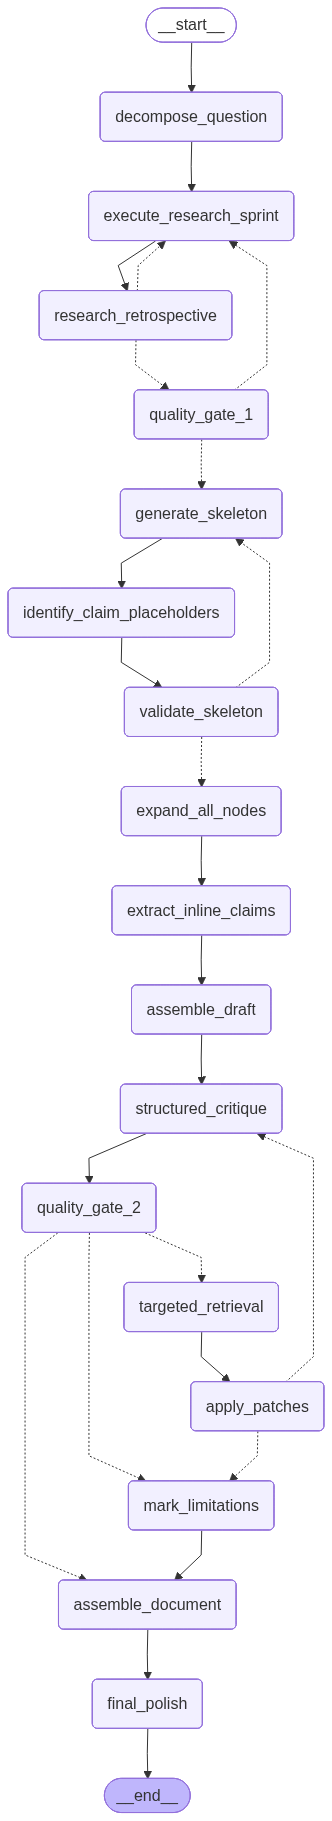

In [95]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(combined_tier1_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 15. Agent Wrapper

In [93]:
async def combined_tier1_agent_async(inputs: dict) -> dict:
    """
    Async version of the Combined Tier 1 research agent.
    """
    question = inputs.get("question", "")
    
    # Reset knowledge base for new session
    global knowledge_base
    knowledge_base = KnowledgeBase()
    
    result = await combined_tier1_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    return {
        "output": result.get("final_report", ""),
        "sprint_findings": result.get("sprint_findings", []),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.get_stats_summary(),
        "limitations": result.get("limitations_noted", [])
    }


def combined_tier1_agent(inputs: dict) -> dict:
    """
    Sync wrapper for Combined Tier 1 research agent.
    Compatible with evaluation harness.
    """
    question = inputs.get("question", "")
    
    async def _execute():
        global knowledge_base
        knowledge_base = KnowledgeBase()
        return await combined_tier1_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "sprint_findings": result.get("sprint_findings", []),
        "source_urls": list(set(result.get("research_source_urls", []))),
        "quality_scores": result.get("quality_scores", []),
        "cache_stats": knowledge_base.get_stats_summary(),
        "limitations": result.get("limitations_noted", [])
    }

print("Agent wrappers defined")

Agent wrappers defined


## 16. Manual Test

Run this cell to verify the agent works correctly.

In [94]:
# Test the agent
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Combined Tier 1 Agent with question:\n{test_question}\n")
print("Running combined research agent (this may take several minutes)...\n")

try:
    result = await combined_tier1_agent_async({"question": test_question})
    
    print("="*80)
    print("FINAL REPORT")
    print("="*80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "="*80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Sprint findings: {len(result.get('sprint_findings', []))}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")
    print(f"Quality scores: {result.get('quality_scores', [])}")
    print(f"\n{result.get('cache_stats', '')}")
    if result.get("limitations"):
        print(f"Limitations noted: {result['limitations']}")
    print("Agent test PASSED")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()

Testing Combined Tier 1 Agent with question:
What are the key benefits and challenges of using large language models in enterprise applications?

Running combined research agent (this may take several minutes)...


Phase 1a: Decomposing Research Question
  Created backlog with 6 research questions

Sprint 1/2: What measurable business outcomes (e.g., productivity gains, cost redu...
  Searching: What measurable business outcomes (e.g., productiv...
  Searching: ("measurable business outcomes" OR "quantified res...
  Searching: ("highest ROI" OR "best ROI" OR "top ROI" OR "most...
  Synthesized 4759 characters
  Collected 12 source URLs
  Retrospective: Continue, 7 questions

Continuing to sprint 2. 7 questions remaining.

Sprint 2/2: Data security, privacy, and regulatory-compliance risks with LLMs (inc...
  Searching: Data security, privacy, and regulatory-compliance ...
  Searching: ("large language model" OR LLM) AND ("data leakage...
  Searching: ("private inference" OR "on‑prem" O

In [96]:
display(Markdown(result["output"]))

# Research Report

**Thesis:** Large language models can deliver substantial, measurable benefits in scoped enterprise workflows (contact centers, process automation, CRM, and knowledge work) but realizing those gains at scale requires disciplined pilots, rigorous KPIs, and a layered security/privacy and contractual strategy that balances cloud delivery speed against third‑party exposure.


## Introduction

This report opens by framing why enterprises are rapidly experimenting with large language models (LLMs) while also needing a sober, risk‑aware approach.

Large language models are delivering material, measured gains in focused enterprise workflows — but they are not a plug‑and‑play panacea. High‑visibility vendor and customer case studies show rapid, tangible outcomes: one contact‑center deployment reported a 40% reduction in Average Handle Time (AHT), translating into direct cost‑per‑contact savings and capacity gains (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12). EchoStar’s Hughes division used Azure AI Foundry to put 12 production applications into service (sales call auditing, retention analysis, field‑service automation), illustrating how cloud+AI platforms accelerate app delivery (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/). CRM vendors likewise report “millions of dollars saved” by automating call summaries, record updates, and next‑best action workflows (Source: https://deselect.com/blog/ai-for-crm-how-to-turn-customer-data-into-revenue-in-2026/).

At the same time, independent analyses counsel caution. Broad enterprise AI programs often yield modest enterprise‑wide ROI unless tightly scoped — IBM’s assessment showed average enterprise AI ROI near 5.9% (Source: https://www.ibm.com/think/insights/ai-roi). Measurement gaps are common: many headline metrics are vendor‑reported or case‑study based, underscoring the need for controlled pilots and TEI‑style evaluations before scaling. Security, privacy, and compliance concerns are equally consequential: documented risks include data leakage, prompt‑injection and model‑inversion attacks, and non‑technical exposures in logs and telemetry; expert reports recommend layered technical controls plus contractual safeguards (Sources: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf; https://cloudatg.com/).

This report therefore argues: LLMs can deliver substantial, measurable benefits in scoped enterprise workflows (contact centers, process automation, CRM, and knowledge work), but realizing gains at scale requires disciplined pilots, rigorous KPIs, and a layered security/privacy and contractual strategy that balances cloud delivery speed against third‑party exposure. The evidence base combines vendor case studies, independent analyses, and security expert reports cited throughout.

The next section reviews LLM technical foundations and background assumptions that underpin both the opportunities and the risks described here.


## Background and Technical Foundations

To ground the report’s claims about opportunity and risk, this section summarizes what LLMs are, how enterprises typically deploy them, and the basic threat surface and regulatory context that shape controls and tradeoffs.

Large language models (LLMs) are statistical neural networks trained on large text corpora to predict and generate human-like language; in enterprise use they are applied as generation, summarization, classification, and retrieval-augmented components. Typical deployment patterns include: (1) cloud API consumption of third‑party hosted models, (2) managed/virtual private inference (cloud-managed services with VPC or private endpoints, e.g., Azure AI Foundry used for multi-app delivery) (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/), and (3) on‑premises or private inference (self-hosted GPU clusters or appliance-based inference) to reduce external exposure. Each architecture trades delivery speed, scalability, and cost against control over data, telemetry, and vendor access. 

The enterprise threat surface centers on data exposure (PII/PHI), model-based attacks, and operational telemetry. Practical vectors include memorized leakage and model inversion, prompt‑injection and reprompt-style exfiltration, insecure telemetry/logging that persists user inputs, and leakage during fine‑tuning or when sharing training traces (Source: https://cloudatg.com/; https://medium.com/@bijit211987/llm-privacy-and-security-56a859cbd1cb). Fine‑tuning and feedback telemetry are especially sensitive because they can embed customer data into model parameters or logs; controllers must treat these artifacts as potential personal data (Source: expert report: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf).

Regulatory obligations under GDPR and CCPA apply when LLMs process personal data: lawful basis, purpose limitation, data minimization, DPIAs for high‑risk processing, and enabling of data subject rights. Non‑technical exposures (logs, vendor access) can produce compliance failures; contractual safeguards (DPAs, SOC 2, BAAs) complement technical controls (encryption in transit/at rest, VPC/private endpoints, TEEs/HSMs for keys, query filtering, prompt sanitization, RBAC) (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf; https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12). 

These foundations frame later sections’ discussion of high‑ROI use cases and a risk matrix mapping attack vectors to operational and contractual mitigations.

With that technical and regulatory baseline established, the report next examines where LLMs deliver the clearest business value and measurable ROI in scoped enterprise workflows.


## Business Benefits and High‑ROI Use Cases

With the technical foundations and regulatory constraints in view, we next consider where LLMs show the clearest, measurable business value and which workflows are most likely to deliver near‑term ROI.

Enterprises are seeing the strongest, repeatable value from LLMs when models are applied to narrowly scoped workflows that replace routine human effort or accelerate decisionmaking. Four categories have consistent vendor and case‑study support:

- Contact‑center automation: Generative assistants and assisted-agent UIs can materially reduce Average Handle Time (AHT), increase capacity, and cut cost per contact. A vendor case study reports a ~40% reduction in AHT after deploying generative AI across support channels, a level of impact that translates directly to FTE savings or higher throughput (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12). Measured KPIs: AHT, first‑contact resolution, cost per contact, and NPS.

- Process and document automation: Invoice processing, compliance checks, contract triage, and structured-data extraction are high‑ROI targets because they replace repetitive, rules‑driven work and integrate well with RPA and workflow engines. Vendors and industry write‑ups highlight fast payback in back‑office workflows where accuracy thresholds are achievable and measurable (Source: https://iapptechnologies.com/blog/ai-use-cases-enterprise-roi-2026).

- CRM and sales enablement: Automated call summaries, record updates, and next‑best action recommendations reduce administrative lift and accelerate pipeline management. CRM vendors report “millions of dollars” saved in aggregate for customers who automate these tasks, though outcomes vary by customer size and process maturity (Source: https://deselect.com/blog/ai-for-crm-how-to-turn-customer-data-into-revenue-in-2026/). Key metrics: time saved per rep, data completeness, and revenue uplift.

- Knowledge‑worker and developer productivity: Copilots and code‑assist tools shorten development cycles, reduce debugging time, and speed content creation—benefits that scale with adoption and careful integration into workflows (Source: Microsoft customer stories: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/).

Caveats and measurement guidance: many high‑impact figures come from vendors or single‑customer case studies; independent analyses paint a more conservative picture—IBM reports average enterprise‑wide AI ROI near 5.9% when initiatives are broad rather than tightly scoped (Source: https://www.ibm.com/think/insights/ai-roi). To bridge this gap, run controlled pilots with pre‑specified KPIs (FTE saved, minutes per transaction, AHT, resolution rate, revenue uplift, NPS) and baseline measurements (Source: PwC/Terralogic guidance). Finally, choose deployment models (cloud vs on‑prem) with the workload’s regulatory and telemetry risks in mind; cloud speeds delivery but raises third‑party exposure (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf).

Having identified the high‑ROI opportunities and the measurement discipline required, the report now turns to the security, privacy, and compliance risks that must be mitigated to realize those benefits at scale.


## Security, Privacy, and Compliance Risks

With high‑ROI workflows identified, enterprises must confront a clustered set of technical and non‑technical risks that can erode value or create compliance failures if left unmanaged.

Core technical risks include data leakage via memorization (models reproducing sensitive training tokens), model inversion and membership‑inference attacks that reveal whether specific records were present in training data, and prompt‑injection/reprompt attacks that subvert model behavior to exfiltrate secrets (including reported “single‑click” exfiltration vectors) (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf; Source: https://cloudatg.com/; Source: https://medium.com/@bijit211987/llm-privacy-and-security-56a859cbd1cb). Non‑technical exposures include insecure telemetry and logging (retained prompts, PII in traces), and risk during fine‑tuning or when using third‑party APIs that grant vendors access to raw data. Practical examples: contact‑center summaries that include customer identifiers can be memorized or logged and later exposed if telemetry isn’t sanitized (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12).

Regulatory implications are material: processing personal data through LLMs triggers GDPR/CCPA obligations (lawful basis, purpose limitation, DPIAs where processing is high risk, and honoring data subject rights). Where health or HIPAA‑regulated data is involved, Business Associate Agreements (BAAs) and specific technical safeguards are required; contractual assurances (Data Processing Agreements, SOC 2 reports) are essential complements to engineering controls (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf).

Recommended technical controls include private/on‑prem or VPC‑restricted inference to limit third‑party access (tradeoff: slower time‑to‑value vs lower exposure, illustrated by Azure-powered rapid delivery at scale) (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/). Enforce encryption in transit/at rest, use TEEs/HSMs for key isolation, apply data minimization and prompt sanitization, and implement prompt‑filtering and robust telemetry retention policies. Consider differential‑privacy techniques or synthetic data for fine‑tuning, and strict role‑based access control for model ops (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf). Contractual controls should mandate DPAs, SOC 2/audit evidence, BAAs where applicable, and clear SLAs on logging/retention and incident response. Finally, validate protections via DPIAs, red‑team prompt‑injection tests, and scoped pilots with measurable KPIs before scaling (Source: https://www.ibm.com/think/insights/ai-roi; Source: https://terralogic.com/ai-applications-in-business-trends-opportunities-challenges-2026/).

Having cataloged risks and controls, the report next examines deployment models and operational tradeoffs that determine how those mitigations are implemented in practice.


## Deployment Models and Operational Challenges

With risks and mitigations mapped in the previous section, deployment choices determine which controls are practical and how quickly business value can be realized.

Enterprises face a clear dichotomy: adopt cloud‑managed AI platforms for rapid delivery and rich ecosystems, or insist on private/on‑prem inference to minimize third‑party exposure. Cloud platforms accelerate time‑to‑production through managed tooling, connectors, and orchestration — for example, EchoStar used Azure AI Foundry to deliver 12 production applications across sales, retention, and field service (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/). Contact‑center vendors likewise report large operational gains (vendor case study: 40% AHT reduction) that are easiest to realize via cloud delivery (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12). 

Those speed and ecosystem advantages come with operational and contractual tradeoffs. Cloud inference commonly produces telemetry, logs, and model‑interaction data that can create compliance and IP exposures unless contractual and technical safeguards (DPAs, SOC2, BAAs; VPC isolation, telemetry controls) are in place (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf). By contrast, on‑prem or private inference reduces vendor access and data exfiltration risk but increases capital and operational cost (hardware, cooling, HSMs/TEEs), slows model updates, and adds integration burden across CI/CD, monitoring, and data pipelines.

Practically, organizations struggle with cost forecasting, integration complexity, observability of model quality and drift, and lifecycle governance (fine‑tuning, rollback, and controlled updates). Many published ROI figures are vendor‑led; independent evaluations are scarce, creating measurement gaps that make enterprise scaling risky. Independent analysis has shown that broad, unfocused AI programs often deliver modest enterprise‑level ROI (~5.9%), underscoring the value of scoped pilots with pre‑defined KPIs (Source: https://www.ibm.com/think/insights/ai-roi; see guidance on scoping and KPIs: https://www.pwc.com/us/en/tech-effect/ai-analytics/ai-predictions.html).

Given these operational tradeoffs and evidence limitations, the next section analyzes how to structure pilots and measurement frameworks that balance speed, security, and measurable ROI.


## Analysis and Discussion

Building on the operational tradeoffs outlined above, this section synthesizes evidence into practical frameworks that help teams prioritize use cases, run disciplined pilots, and map concrete controls to known attack vectors.

1) Evidence‑weighted risk–benefit matrix: map high‑ROI workflows against security exposure and expected ROI. Empirical and vendor reports converge on four high‑priority buckets: contact‑center automation (large AHT reductions reported; vendor case: 40% AHT drop) (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12), document/process automation and RAG‑backed knowledge tools (high ROI, controllable data scope) (Source: https://iapptechnologies.com/blog/ai-use-cases-enterprise-roi-2026), CRM/sales enablement (significant vendor‑reported revenue/admin savings) (Source: https://deselect.com/blog/ai-for-crm-how-to-turn-customer-data-into-revenue-in-2026/), and developer/knowledge worker copilots (productivity gains). Independent analyses temper enterprise‑wide ROI expectations (e.g., IBM ~5.9% average) and highlight that tightly scoped pilots outperform broad programs (Source: https://www.ibm.com/think/insights/ai-roi).

2) Recommended pilot framework and KPIs: run short (6–12 week) controlled pilots with pre‑defined KPIs and measurement guidance. Core KPIs: FTE saved (modeled from time‑and‑motion baselines), minutes per transaction, Average Handle Time (AHT), resolution rate, revenue uplift (attributable lift), and NPS/CSAT. Measurement guidance: capture pre/post baselines, use A/B or randomized rollout where feasible, instrument latency/error/rollback metrics, log human overrides, and ensure sample sizes and confidence intervals are calculated. Vendors and consultancies recommend scoping to single workflows, setting clear success thresholds, and requiring independent validation before scale (Source: https://www.pwc.com/us/en/tech-effect/ai-analytics/ai-predictions.html; https://terralogic.com/ai-applications-in-business-trends-opportunities-challenges-2026/).

3) Controls mapping (attack vector → mitigations):
- Prompt‑injection: input validation, prompt templates, output sanitization, adversarial red‑teaming (Source: https://cloudatg.com/).
- Exfiltration/memorization: data minimization, context window controls, RAG with sanitized indices, private inference/VPC or on‑prem inference (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf).
- Telemetry/logging leakage: strict logging policies, PII redaction, contractual guarantees (DPA, SOC2, BAA), and encrypted telemetry pipelines.
- Model inversion/membership inference: differential privacy for fine‑tuning, access controls, TEEs/HSMs for key management.

Across all mappings, combine technical barriers with contractual assurances and DPIAs. Recognize evidence gaps: many ROI claims are vendor‑reported and cloud platforms accelerate delivery (EchoStar on Azure) but increase third‑party exposure—tradeoffs must be evaluated per use case (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/; Source: https://www.ibm.com/think/insights/ai-roi).

The following section draws conclusions and prescriptive recommendations that operationalize these frameworks for executive decision‑making and rollout governance.


## Conclusion and Recommendations

Building on the frameworks in the previous section, we now synthesize where LLMs provide the clearest enterprise value, which risks require mitigation, and the concrete next steps leaders should take to move from pilots to safe scale.

LLMs are most likely to deliver measurable, near-term enterprise value when applied to narrowly scoped workflows that produce time- or cost‑based KPIs: contact‑center automation (notably AHT and resolution improvements; vendor case study: 40% AHT reduction) (Source: https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12); document and process automation (invoicing, compliance checks, onboarding) and CRM/sales enablement (automated summaries, record updates, next‑best action) (Source: https://deselect.com/blog/ai-for-crm-how-to-turn-customer-data-into-revenue-in-2026/; https://iapptechnologies.com/blog/ai-use-cases-enterprise-roi-2026); and knowledge‑worker copilot scenarios that increase developer and analyst productivity (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/). At the same time, core security and compliance risks—data leakage via memorization, prompt‑injection and reprompt attacks, model inversion/membership inference, insecure telemetry/logging, and exposures during fine‑tuning or third‑party inference—must be managed through a mix of technical and contractual controls (Source: https://cloudatg.com/; https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf). Regulatory obligations under GDPR/CCPA amplify non‑technical requirements (DPIAs, lawful basis, data minimization) and make contractual assurances (DPAs, SOC2, BAAs) essential complements to engineering controls (Source: https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf). Prioritized recommendations: 1) Run controlled pilots on high‑ROI workflows with pre‑defined KPIs (FTE saved, AHT, minutes per transaction, revenue uplift, NPS) and baseline measurements; validate results via independent TEI‑style evaluation rather than relying only on vendor case studies (Source: https://www.ibm.com/think/insights/ai-roi). 2) Implement layered controls: private or VPC‑restricted inference where required, encryption, TEEs/HSMs for keys, prompt‑sanitization, telemetry policies, RBAC, and contractual assurances. 3) Choose deployment model per regulatory context—favor on‑prem/isolated inference for high‑sensitivity data, cloud for rapid app delivery where controls suffice (Source: https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/). 4) Commission independent TEI/Forrester‑style evaluations for scaling decisions to correct for vendor optimism. Finally, maintain a measurement plan that tracks both business KPIs and security telemetry to detect regressions early.

The following materials provide an implementation checklist and sample pilot protocol to operationalize these recommendations and the KPI-driven methodology described earlier.


## Limitations and Caveats

The following aspects could not be fully addressed:

- The full document is truncated mid-sentence in the Security section ("Consider differential‑privacy te...") and the subsequent sections (Deployment Models and Operational Challenges, Analysis and Discussion, Conclusion and Recommendations) are missing or incomplete. This prevents assessment of key arguments, mitigations, deployment guidance, the promised risk‑benefit matrix, and final recommendations that are central to the thesis.
- Many headline benefit figures (AHT reductions, 'millions of dollars saved', multi-application rollouts) are sourced to vendor blogs and single‑customer case studies. The report relies heavily on these sources without sufficient independent, systematically gathered evidence or methodologically described evaluations.
- Security mitigations are asserted at a high level (VPCs, TEEs/HSMs, prompt filtering, telemetry policies) but the discussion is truncated and lacks implementation detail, tradeoffs, cost implications, monitoring strategies, and references to authoritative security frameworks and advisories.
- The Deployment Models and Operational Challenges section is absent from the supplied full text. The thesis explicitly depends on a 'layered security/privacy and contractual strategy' and a 'cloud-vs-onprem decision framework', but the document does not contain the promised operational guidance or evaluation of deployment tradeoffs.
- The Analysis and Discussion section is missing. The report promises an 'evidence-weighted risk‑benefit matrix' and discussion of enterprise-wide ROI heterogeneity, but does not present those artifacts, quantitative analyses, or sensitivity checks.

## References

1. https://www.yourdictionary.com/large
2. https://www.thefreedictionary.com/Large
3. https://iapptechnologies.com/blog/ai-use-cases-enterprise-roi-2026
4. https://www.oxfordlearnersdictionaries.com/definition/american_english/large
5. https://www.microsoft.com/en-us/microsoft-cloud/blog/2025/07/24/ai-powered-success-with-1000-stories-of-customer-transformation-and-innovation/
6. https://negd.gov.in/wp-content/uploads/2025/12/document-3.pdf
7. https://cloudatg.com/
8. https://arxiv.org/list/cs/new
9. https://cloudsecurityalliance.org/blog/2024/08/22/understanding-the-differences-between-fully-homomorphic-encryption-and-confidential-computing
10. https://www.merriam-webster.com/dictionary/large
11. https://dictionary.cambridge.org/dictionary/english/large
12. https://medium.com/@bijit211987/llm-privacy-and-security-56a859cbd1cb
13. https://hazyresearch.stanford.edu/blog/2025-05-12-security
14. https://arxiv.org/abs/2509.01253
15. https://terralogic.com/ai-applications-in-business-trends-opportunities-challenges-2026/
16. https://next.redhat.com/2025/10/23/enhancing-ai-inference-security-with-confidential-computing-a-path-to-private-data-inference-with-proprietary-llms/
17. search://516675066044b5a2
18. https://onereach.ai/blog/agentic-ai-adoption-rates-roi-market-trends/
19. https://intuitionlabs.ai/articles/private-llm-pharma-compliance-architecture
20. search://0aeb7c246887b098
21. https://www.aigl.blog/content/files/2025/07/Privacy-and-Data-Protection-Risks-in-Large-Language-Models--LLMs-.pdf
22. https://data.www.sbir.gov/mod_awarddatapublic/award_data.csv
23. https://www.wordreference.com/definition/large
24. https://www.uhd.nhs.uk/assets/uploads/members/Board-of-Directors-Part-1-14-January-2026.pdf
25. https://www.ibm.com/think/insights/ai-roi
26. https://www.reddit.com/r/cryptography/comments/1q1hqq0/homomorphic_encryption_for_llm_inference_is_it/
27. https://www.pwc.com/us/en/tech-effect/ai-analytics/ai-predictions.html
28. https://www.agilesoftlabs.com/blog/2026/01/generative-ai-in-enterprises-12
29. https://www.gartner.com/ngw/globalassets/en/information-technology/documents/top-10-strategic-technology-trends-for-2018.pdf.
30. https://www.collinsdictionary.com/dictionary/english/large


# Test Execution Section

This section runs the 5-query test dataset against this notebook variant and saves outputs for comparison.

**Output Structure:**
```
test_output/
    question_1/
        question_1_V08-1.md
    question_2/
        question_2_V08-1.md
    ...
```

**Instructions:**
1. Run all cells above first to define the agent
2. Run the cells below to execute tests
3. Choose to run a single question or all questions

In [ ]:
# Test Setup and Configuration
import os
import yaml
import json
from datetime import datetime
from pathlib import Path

# Configure paths
NOTEBOOK_DIR = Path('.').resolve()
OUTPUT_DIR = NOTEBOOK_DIR / 'test_output'
DATASET_PATH = NOTEBOOK_DIR / 'test_dataset.yaml'

# Notebook version (automatically set based on filename)
CURRENT_VERSION = "V08-1"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load test dataset
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = yaml.safe_load(f)

questions = dataset.get('questions', [])

# Create output directories for each question
for i in range(1, len(questions) + 1):
    question_dir = OUTPUT_DIR / f"question_{i}"
    question_dir.mkdir(exist_ok=True)

print(f"Test Configuration:")
print(f"  Version: {CURRENT_VERSION}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Loaded {len(questions)} test questions")
print(f"\nTest Questions:")
for i, q in enumerate(questions, 1):
    print(f"  {i}. [{q['category']}] {q['title']}")

In [ ]:
def save_output(question_num: int, version: str, result: dict, question_data: dict) -> Path:
    """Save the output to a markdown file."""
    output_dir = OUTPUT_DIR / f"question_{question_num}"
    output_file = output_dir / f"question_{question_num}_{version}.md"
    
    question_text = question_data.get('question', '')
    question_title = question_data.get('title', 'Untitled')
    question_id = question_data.get('id', f'Q{question_num}')
    
    content = f"""# Question {question_num} - {version}

                **Question ID:** {question_id}  
                **Title:** {question_title}  
                **Category:** {question_data.get('category', 'N/A')}  

                ---

                ## Original Question

                {question_text}

                ---

                ## Research Report

                {result.get('output', 'No output generated')}

                """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)
    
    return output_file

print("Helper functions defined.")

## Run All Questions Test

Run ALL 5 questions for comprehensive testing:

**WARNING:** This will take 30-60+ minutes to complete.

In [ ]:
# Run ALL questions for the current version
# WARNING: This will take a long time (potentially 30-60+ minutes)

print(f"Running ALL {len(questions)} questions with {CURRENT_VERSION}")
print(f"Estimated time: 30-60+ minutes")
print("="*60 + "\n")

results_summary = []
overall_start = datetime.now()

for i, question_data in enumerate(questions, 1):
    question_text = question_data.get('question', '')
    
    print(f"\n{'='*60}")
    print(f"Question {i}/{len(questions)}: {question_data['title']}")
    print(f"{'='*60}\n")
    
    start_time = datetime.now()
    
    try:
        result = await combined_tier1_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()
        
        output_file = save_output(i, CURRENT_VERSION, result, question_data)
        
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": len(result.get('output', '')),
            "sources": len(result.get('source_urls', [])),
            "status": "success"
        }
        
        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")
        
    except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": 0,
            "sources": 0,
            "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")
    
    results_summary.append(summary)

# Save summary
overall_elapsed = (datetime.now() - overall_start).total_seconds()

summary_file = OUTPUT_DIR / f"summary_{CURRENT_VERSION}.json"
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump({
        "run_time": datetime.now().isoformat(),
        "version": CURRENT_VERSION,
        "total_elapsed_seconds": overall_elapsed,
        "questions_tested": len(questions),
        "results": results_summary
    }, f, indent=2)

print(f"\n{'='*60}")
print(f"ALL TESTS COMPLETE for {CURRENT_VERSION}")
print(f"{'='*60}")
print(f"Total time: {overall_elapsed:.1f} seconds ({overall_elapsed/60:.1f} minutes)")
print(f"Summary saved: {summary_file}")